In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 80% !important; }</style>"))

In [3]:
import sys
import time
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import colors

In [4]:
myColors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
            '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
            '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
            '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
            '#307D7E', '#000000', "#DDEFFF", "#000035", "#7B4F4B", 
            "#A1C299", "#300018", "#C2FF99", "#0AA6D8", "#013349", 
            "#00846F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", 
            "#1E6E00", "#DFFB71", "#868E7E", "#513A01", "#CCAA35"]

colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [5]:
import smashpy
sf = smashpy.smashpy()

 * Initialising ...



In [7]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.core import Dense, Dropout, Activation, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import losses, optimizers, regularizers
from tensorflow.python.keras.layers.normalization import BatchNormalization

# Loading annData object

In [8]:
obj = sc.read_h5ad('../../../../../External_datasets/mouse_brain_all_cells_20200625_with_annotations.h5ad')
obj.X = obj.X.toarray()
obj = obj[obj.obs["Cell broad annotation"]=="Astro"]

In [9]:
obj.X = obj.X.toarray()

In [10]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

31053 genes across 3013 cells


In [11]:
new_sub_annotation = []
for c in obj.obs["Cell sub annotation"].tolist():
    if c in ['Astro_AMY', 'Astro_AMY_CTX', 'Astro_CTX']:
        new_sub_annotation.append('Astro_AMY_CTX')
    elif c in ['Astro_THAL_hab', 'Astro_THAL_lat', 'Astro_THAL_med']:
        new_sub_annotation.append('Astro_THAL')
    else:
        new_sub_annotation.append(c)
obj.obs["Cell sub annotation"] = new_sub_annotation
obj.obs["Cell sub annotation"] = obj.obs["Cell sub annotation"].astype("category")

Trying to set attribute `.obs` of view, copying.


In [12]:
obj.obs["Cell sub annotation"].value_counts()

Astro_AMY_CTX    1220
Astro_THAL        780
Astro_HYPO        451
Astro_HPC         261
Astro_WM          220
Astro_STR          81
Name: Cell sub annotation, dtype: int64

#### Data preparation

In [13]:
sf.data_preparation(obj)

#### Removing general genes

In [14]:
s1 = time.time()

In [15]:
obj = sf.remove_general_genes(obj, species='mouse')

#### Removing house-keeping genes

http://www.housekeeping.unicamp.br/?homePageGlobal

In [16]:
obj = sf.remove_housekeepingenes(obj, path="../../../data/house_keeping_genes_Mouse_cortex.txt")

#### Removing genes expressed in less than 30% within groups

In [17]:
obj = sf.remove_features_pct(obj, group_by="Cell sub annotation", pct=0.3)

#### Removing genes expressed in more than 50% in a given group where genes are expressed for more 75% within a given group

In [18]:
obj = sf.remove_features_pct_2groups(obj, group_by="Cell sub annotation", pct1=0.75, pct2=0.5)

#### Revert PCA

In [19]:
obj = sf.scale_filter_features(obj, n_components=None, filter_expression=True)

Fraction passing PCA: 1.0


In [20]:
obj.var.set_index(obj.var["SYMBOL"], inplace=True, drop=False)
obj.var.index.name = None

#### DNN

In [21]:
s2 = time.time()

In [22]:
num_classes = len(obj.obs["Cell sub annotation"].cat.categories)

model = Sequential()

model.add(Dense(64, input_shape=(obj.X.shape[1],))) #1°layer
# model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(Dropout(0.1))

# model.add(Dense(64, input_shape=(128,))) #2°layer
# # model.add(BatchNormalization())
# model.add(Activation('sigmoid'))
# # model.add(Dropout(0.1))

model.add(Dense(16, input_shape=(64,))) #3°layer
# model.add(BatchNormalization())
model.add(Activation('sigmoid'))
# model.add(Dropout(0.1))

model.add(Dense(num_classes, activation='softmax')) #output

model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers.Adam(learning_rate=0.001, amsgrad=False),
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                81088     
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102       
Total params: 82,230
Trainable params: 82,230
Non-trainable params: 0
____________________________________________________

22/22 [==============================] - 0s 7ms/step - loss: 0.2882 - accuracy: 0.9835 - auc: 0.9994 - precision: 0.9880 - recall: 0.9634 - val_loss: 0.5703 - val_accuracy: 0.8241 - val_auc: 0.9770 - val_precision: 0.8687 - val_recall: 0.7688

Epoch 00020: val_loss improved from 0.58282 to 0.57027, saving model to weights/best_model_Cell sub annotation.h5
Epoch 21/100
22/22 [==============================] - 0s 6ms/step - loss: 0.2530 - accuracy: 0.9850 - auc: 0.9997 - precision: 0.9888 - recall: 0.9742 - val_loss: 0.5588 - val_accuracy: 0.8252 - val_auc: 0.9769 - val_precision: 0.8662 - val_recall: 0.7732

Epoch 00021: val_loss improved from 0.57027 to 0.55876, saving model to weights/best_model_Cell sub annotation.h5
Epoch 22/100
22/22 [==============================] - 0s 6ms/step - loss: 0.2311 - accuracy: 0.9862 - auc: 0.9999 - precision: 0.9901 - recall: 0.9765 - val_loss: 0.5560 - val_accuracy: 0.8263 - val_auc: 0.9760 - val_precision: 0.8603 - val_recall: 0.7765

Epoch 00022: v

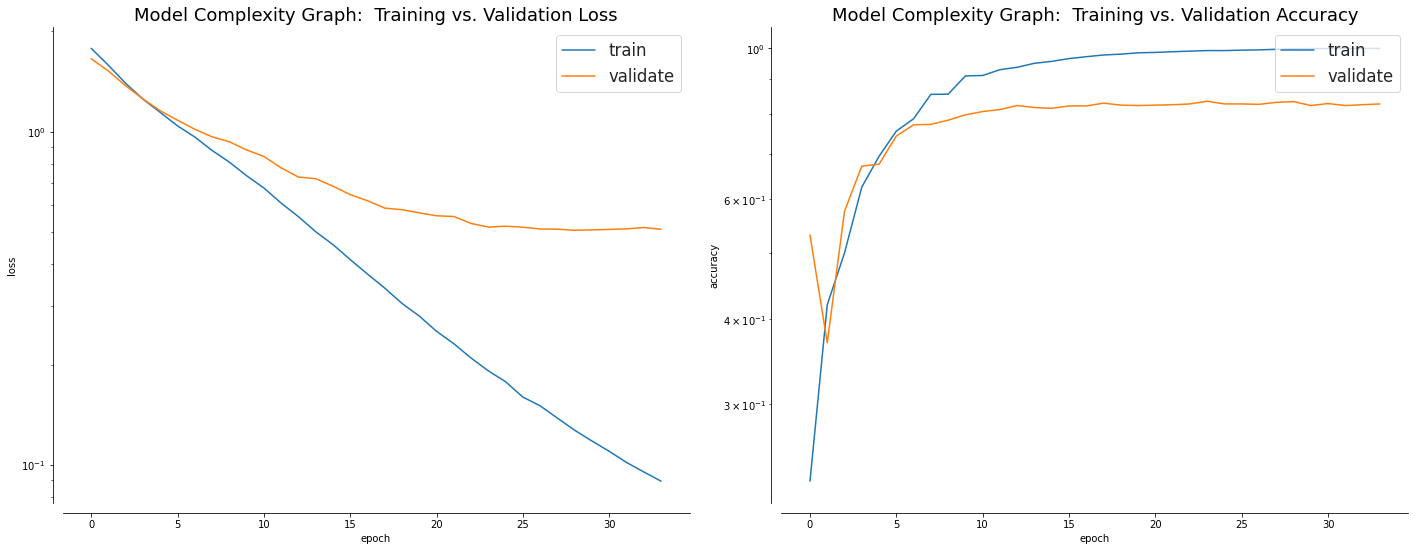

<Figure size 432x288 with 0 Axes>

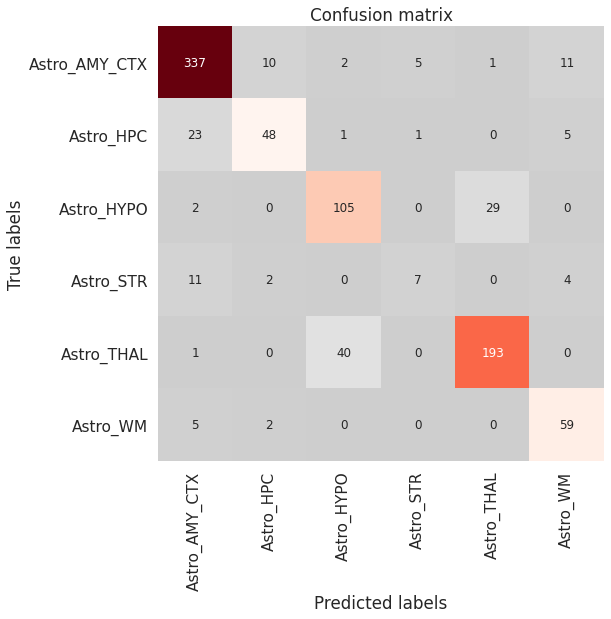

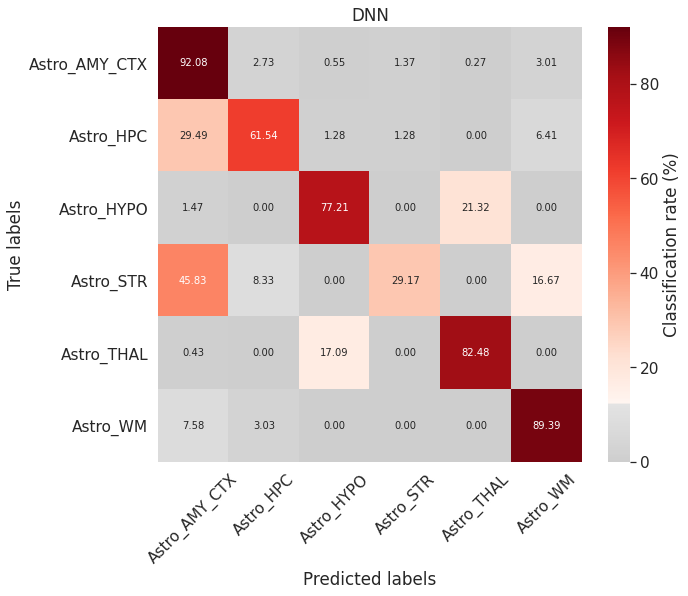

               precision    recall  f1-score   support

Astro_AMY_CTX       0.89      0.92      0.90       366
    Astro_HPC       0.77      0.62      0.69        78
   Astro_HYPO       0.71      0.77      0.74       136
    Astro_STR       0.54      0.29      0.38        24
   Astro_THAL       0.87      0.82      0.84       234
     Astro_WM       0.75      0.89      0.81        66

     accuracy                           0.83       904
    macro avg       0.75      0.72      0.73       904
 weighted avg       0.83      0.83      0.82       904

29/29 [==============================] - 0s 1ms/step - loss: 0.5056 - accuracy: 0.8352 - auc: 0.9758 - precision: 0.8543 - recall: 0.8042


In [23]:
sf.DNN(obj, group_by="Cell sub annotation", model=model, test_size=0.3, balance=True, verbose=True, save=True)

#### Shap value

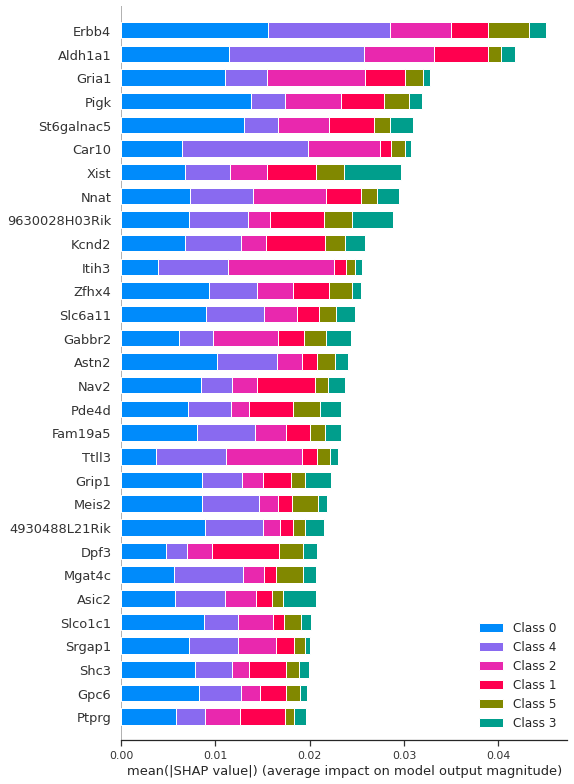

In [24]:
selectedGenes, selectedGenes_dict = sf.run_shap(obj, group_by="Cell sub annotation", model=model, verbose=True, pct=0.2, restrict_top=("local", 20))

In [25]:
e2 = time.time()

#### Classifiers

<Figure size 432x288 with 0 Axes>

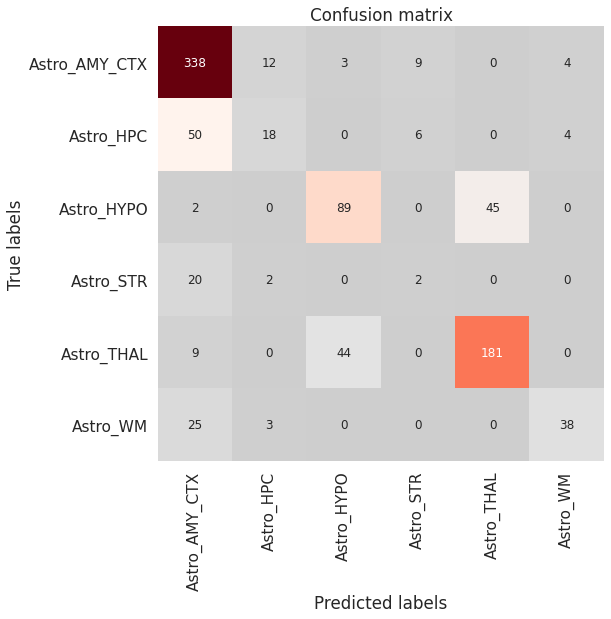

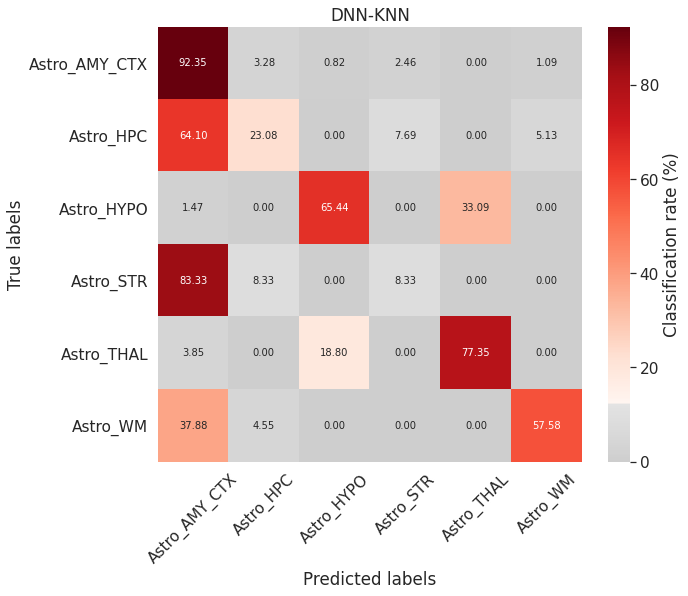

Accuracy: 0.7367256637168141: Misclassification: 0.26327433628318586
               precision    recall  f1-score   support

Astro_AMY_CTX       0.76      0.92      0.83       366
    Astro_HPC       0.51      0.23      0.32        78
   Astro_HYPO       0.65      0.65      0.65       136
    Astro_STR       0.12      0.08      0.10        24
   Astro_THAL       0.80      0.77      0.79       234
     Astro_WM       0.83      0.58      0.68        66

     accuracy                           0.74       904
    macro avg       0.61      0.54      0.56       904
 weighted avg       0.72      0.74      0.72       904



In [26]:
sf.run_classifiers(obj, group_by="Cell sub annotation", genes=selectedGenes, classifier="KNN", balance=True, title="DNN-KNN", save=True)

#### Sorting genes per cluster

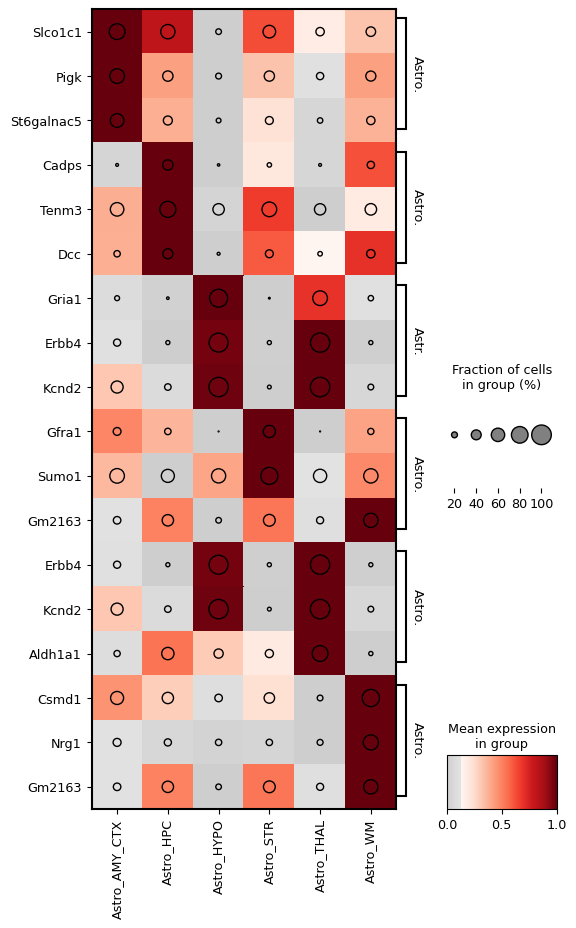

In [27]:
axs, selectedGenes_top_dict = sf.sort_and_plot(obj, selectedGenes, group_by="Cell sub annotation", top=3, figsize=(6,10))

In [28]:
e1 = time.time()

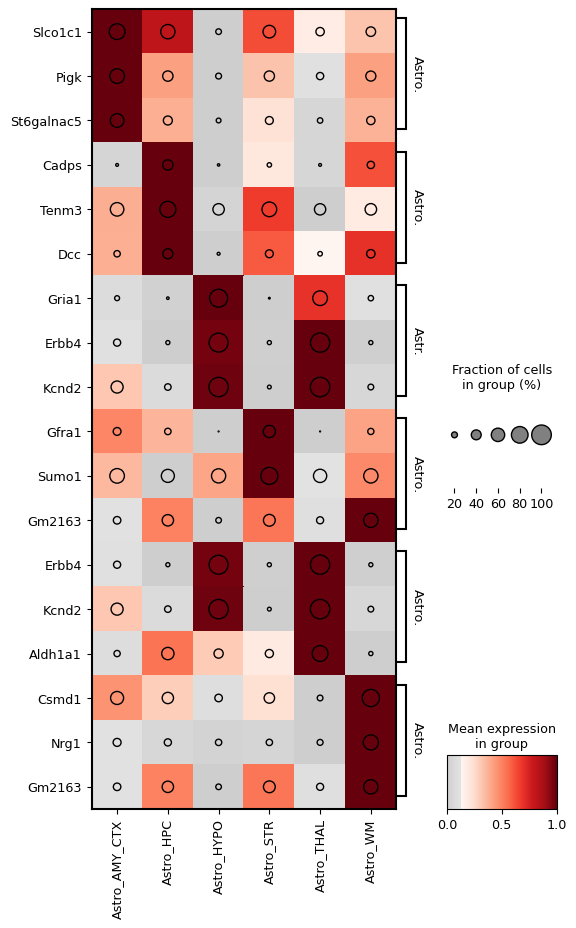

In [29]:
axs.savefig("Figures/DNN_top5_perGroup.pdf")

# Elapsed time

In [30]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

1266 genes across 3013 cells


In [31]:
print('Elapsed time (s): ', e1-s1)

Elapsed time (s):  40.01025056838989


In [32]:
print('Elapsed time (s): ', e2-s2)

Elapsed time (s):  18.401227712631226
